QPU sizes:  {0: 17, 1: 17, 2: 17, 3: 17, 4: 17, 5: 17, 6: 17, 7: 17, 8: 17, 9: 17, 10: 17, 11: 17, 12: 17, 13: 17, 14: 17, 15: 17}


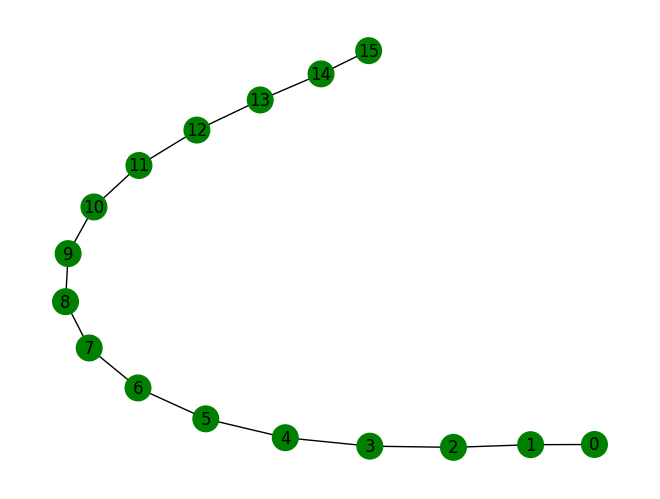

Number of layers: 258
Number of layers: 258
Initial cost with no grouping:  81657
Initial Cost:  52774


In [1]:
from disqco.circuits.cp_fraction import cp_fraction, cz_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from disqco.graphs.hypergraph_methods import calculate_full_cost_hetero
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions
from disqco.circuits.QAOA import QAOA_random
from qiskit.circuit.library import QFT, QuantumVolume
import pickle
from copy import deepcopy
from disqco.graphs.quantum_network import *
from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero
import networkx as nx
import networkx as nx
from copy import deepcopy
import numpy as np

num_qubits = 256

# circuit = QAOA_random(num_qubits, prob = 0.5, reps = 1)

# circuit = QFT(num_qubits,do_swaps = False)

# circuit = QuantumVolume(num_qubits, depth = num_qubits)

circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=num_qubits,
                        fraction= 0.5, seed=5675)

# circuit = cz_fraction(  num_qubits=num_qubits,
                        # depth=num_qubits,
                        # fraction= 0.5)
                        
# circuit = bm.get('bwt_n177')

# num_qubits = circuit.num_qubits


circuit = transpile(circuit, basis_gates = ['cp', 'u'])





import math as mt
import math as mt

def grid_coupling(N):
    """
    Create an adjacency (edge) list for a grid-like connection of N nodes.
    """
    root = int(mt.isqrt(N))
    if root * root == N:
        rows, cols = root, root
    else:
        rows = root
        if rows * root >= N:
            cols = root
        else:
            cols = root + 1
            if rows * cols < N:
                rows += 1

    edges = []
    node_index = lambda r, c: r * cols + c

    for r in range(rows):
        for c in range(cols):
            current_node = node_index(r, c)
            if current_node >= N:
                break

            # Connect to the right neighbor
            if c < cols - 1:
                right_node = node_index(r, c + 1)
                if right_node < N:
                    edges.append([current_node, right_node])

            # Connect to the bottom neighbor
            if r < rows - 1:
                bottom_node = node_index(r + 1, c)
                if bottom_node < N:
                    edges.append([current_node, bottom_node])

    return edges

def network_of_grids(num_grids, nodes_per_grid, l, qpu_size):
    """
    Construct a network of grid graphs connected by linear paths.
    
    Args:
        num_grids (int): Number of grid components.
        nodes_per_grid (int): Number of nodes in each grid.
        l (int): Number of hops (edges) in the path connecting consecutive grids.
        
    Returns:
        edges (List[List[int]]): List of edges for the entire network.
        labels (List[int]): List of length (total_number_of_nodes), 
                            labeling each node by:
                               > i+1 if it belongs to the i-th grid,
                               > 0 if it is a path (bridge) node.
    """
    all_edges = []
    
    # We can compute the total number of nodes:
    #   = (num_grids * nodes_per_grid) + (num_grids - 1) * l
    total_nodes = num_grids * nodes_per_grid + (num_grids - 1) * l
    
    # Prepare a list to label each node.
    # We'll fill it as we go, one entry per node index.
    labels = [None] * total_nodes
    
    # Keep track of where to place new nodes (their indices).
    node_counter = 0
    
    # For each grid:
    for i in range(num_grids):
        # 1) Build the i-th grid (0-based)
        grid_edges = grid_coupling(nodes_per_grid)
        
        # 2) Offset these edges by the current node_counter
        offset_edges = [[u + node_counter, v + node_counter] 
                        for (u, v) in grid_edges]
        all_edges.extend(offset_edges)
        
        # 3) Label all grid nodes with i+1 
        #    (so the 0-th grid => label 1, 1-st grid => label 2, etc.)
        for n in range(nodes_per_grid):
            labels[node_counter + n] = qpu_size
        
        # 4) Advance node_counter past this grid
        start_of_grid = node_counter
        node_counter += nodes_per_grid
        
        # 5) If this isn't the last grid, create a path of length l
        #    bridging from the exit node of the current grid to 
        #    the entry node of the next grid.
        #
        #    We'll define:
        #        - exit_node = (node_counter - 1) from current grid
        #        - next_entry_node = (node_counter + l) [the first node of next grid, eventually]
        #        - l new intermediate nodes from node_counter .. node_counter + l -1
        #    All those intermediate nodes are bridging nodes => label 0.
        #    Then we connect [exit_node -> bridging_0 -> bridging_1 -> ... -> bridging_(l-1) -> next_grid_entry].
        
        if i < num_grids - 1:
            exit_node = node_counter - 1  # last node in the current grid
            bridging_nodes = list(range(node_counter, node_counter + l))
            next_entry_node = node_counter + l  # first node of the next grid (not created yet but index is known)
            
            # Label bridging nodes as 0
            for bn in bridging_nodes:
                labels[bn] = 0
            
            # Build the path edges 
            # "exit_node -> bridging_nodes -> next_entry_node"
            path_chain = [exit_node] + bridging_nodes + [next_entry_node]
            for idx in range(len(path_chain) - 1):
                all_edges.append([path_chain[idx], path_chain[idx+1]])
            
            # Advance node_counter past these bridging nodes
            node_counter += l
    
    return all_edges, labels



# coupling = grid_coupling(num_partitions)


# coupling = random_coupling(num_partitions, 0.5)

# coupling = None


num_partitions = 16

coupling = linear_coupling(num_partitions)

# coupling = grid_coupling(num_partitions)

# coupling = random_coupling(num_partitions, 0.1)

# coupling = tree_network(num_partitions, 5)

qpu_sizes = [int(np.ceil(num_qubits/num_partitions))+1 for i in range(num_partitions)]


initial_qpu_sizes = {i: qpu_sizes[i] for i in range(num_partitions)}
print("QPU sizes: ", initial_qpu_sizes)


from disqco.graphs.quantum_network import QuantumNetwork



initial_network = QuantumNetwork(qpu_sizes, coupling)
initial_network.draw()
network = deepcopy(initial_network)
initial_graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
depth = initial_graph.depth

graph_no_grouping = QuantumCircuitHyperGraph(circuit, group_gates = False, anti_diag = True)


graph = deepcopy(initial_graph)
assignment = set_initial_partitions(network, num_qubits, depth)

initial_cost_no_grouping = calculate_full_cost_hetero(hypergraph=graph_no_grouping, assignment=assignment, num_partitions=num_partitions, costs = {}, network=network)

print("Initial cost with no grouping: ", initial_cost_no_grouping)

initial_cost = calculate_full_cost_hetero(hypergraph=graph, assignment=assignment, num_partitions=num_partitions, costs = {}, network=network)

print("Initial Cost: ", initial_cost)

%load_ext jupyter_tikz

In [2]:
from disqco.parti.FM.net_coarsened_FM import run_net_coarsened_FM

cost, final_assignment = run_net_coarsened_FM(graph, network, l=4, multiprocessing=True, level_limit=8 , passes_per_level=10)

print("Final Cost: ", cost)

Time to coarsen graph: 1.66 seconds
Time for multilevel FM: 72.97 seconds
Time to coarsen graph: 1.22 seconds
Time to coarsen graph: 1.23 seconds
Time to coarsen graph: 1.24 seconds
Time to coarsen graph: 1.24 seconds
Time for multilevel FM: 22.23 seconds
Time for multilevel FM: 22.52 seconds
Time for multilevel FM: 22.59 seconds
Time for multilevel FM: 23.07 seconds
Final Cost:  47805


In [3]:
def post_process_assignment(final_assignment, qpu_sizes, num_partitions):
    """
    Post-process the final assignment to ensure that no partition exceeds its QPU size limit.
    If a partition exceeds its limit, move a qubit from the previous layer to the current layer.
    """
    for t, layer in enumerate(final_assignment):
        for j in range(num_partitions):
            num_js = layer.count(j)
            if num_js > qpu_sizes[j]:
                print(f"Partition {j} exceeds its QPU size limit with {num_js} qubits.")
                qubits_in_j = set([idx for idx, val in enumerate(layer) if val == j])
                qubits_in_j_prev_layer = set([idx for idx, val in enumerate(final_assignment[t-1]) if val == j])
                # Find element in current layer that is not in the previous layer
                for idx in qubits_in_j:
                    if idx not in qubits_in_j_prev_layer:
                        qubit_to_move = idx
                        final_assignment[t][qubit_to_move] = final_assignment[t-1][qubit_to_move]
                        return False, final_assignment  # Return False to indicate that a qubit was moved
                # assign partition from previous layer to current layer
    print(f"All capacities are satisfied.")
    return True, final_assignment

done = False

while not done:
    done, final_assignment = post_process_assignment(final_assignment, qpu_sizes, num_partitions)


Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 2 exceeds its QPU size limit with 18 qubits.
Partition 1 exceeds its QPU size limit with 18 qubits.
Partition 6 exceeds its QPU size limit with 18 qubits.
Partition 5 exceeds its QPU size limit with 18 qubits.
Partition 6 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 2 exceeds its QPU size limit with 18 qubits.
Partition 1 exceeds its QPU size limit with 18 qubits.
Partition 6 exceeds its QPU size limit with 18 qubits.
Partition 5 exceeds its QPU size limit with 18 qubits.
Partition 6 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 3 exceeds its QPU size limit with 18 qubits.
Partition 

In [4]:
from disqco.parti.FM.FM_hetero import run_FM_hetero

refined_cost, refined_assignment, _ = run_FM_hetero(initial_graph, final_assignment, initial_qpu_sizes, num_partitions,
                                                    passes=1, limit=1, network = initial_network, log=True,
                                                    costs={}
                                                    )



Initial cost: 47854
All passes complete.
Final cost: 47847


In [5]:
# from disqco.parti.FM.multilevel_FM import MLFM_recursive_hetero_mapped
# list_ass, cost_list_rec, _ = MLFM_recursive_hetero_mapped(initial_graph, refined_assignment, initial_qpu_sizes, num_partitions,network=initial_network, costs = None, log=True,level_limit=5)

In [6]:
list_ass, cost_list_rec, _ = MLFM_recursive_hetero(initial_graph, assignment, initial_qpu_sizes, num_partitions,network=initial_network, costs = {}, log=True, level_limit=None)

Time to coarsen graph: 1.97 seconds
Initial cost: 52774


KeyboardInterrupt: 

In [ ]:
# draw_graph_tikz(initial_graph, list_ass[-1], initial_qpu_sizes)